<a href="https://colab.research.google.com/github/chandank21/Electrical-Household-Load-Forecasting/blob/main/Load_Forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_data(file_dir):
    dataset=pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    
    #remove that row whuch has not any value...
    dataset.drop(index=dataset[dataset['Global_active_power']=='?'].index,inplace=True)
    dataset.to_csv('file1.csv')
    return dataset

In [4]:
dataset = load_data(r'/content/drive/MyDrive/datasets/household_power_consumption.txt')

In [5]:
dataset=dataset.astype('float32')

In [6]:
new_data=dataset[['Global_active_power']].resample('1H').mean()

In [7]:
new_data.dropna(inplace=True)
new_data.sort_index(inplace=True)

In [8]:
date_index=new_data.index.to_series()

In [9]:
new_data['year']=date_index.dt.year

In [10]:
new_data = new_data.reset_index(drop=True)

In [11]:
new_data.drop('year', axis=1, inplace=True)

In [12]:
new_data.head()

,Global_active_power
0,4.222889
1,3.632200
2,3.400233
3,3.268567
4,3.056467


In [119]:
WINDOW_SIZE = 300
df_as_np = new_data.to_numpy()
X = []
y = []
for i in range(len(df_as_np)-WINDOW_SIZE):
  row = [[a] for a in df_as_np[i:i+WINDOW_SIZE]]
  X.append(row)
  label = df_as_np[i+WINDOW_SIZE]
  y.append(label)
X1,y1 =np.array(X), np.array(y)

In [120]:
X1.shape,y1.shape

((33868, 300, 1, 1), (33868, 1))

In [121]:
train_input = X1[:23000]
test_input = X1[26000:]
validation_input = X1[23000:26000]
train_target = y1[:23000]
test_target = y1[26000:]
validation_target = y1[23000:26000]

In [122]:
train_input.shape,test_input.shape,train_target.shape,test_target.shape

((23000, 300, 1, 1), (7868, 300, 1, 1), (23000, 1), (7868, 1))

# Models...

**model1..LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((300, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

In [125]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=RootMeanSquaredError())

In [126]:
model1.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp1])

Epoch 1/10
719/719 [==============================] - ETA: 0s - loss: 0.5021 - root_mean_squared_error: 0.7086

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 107s 146ms/step - loss: 0.5021 - root_mean_squared_error: 0.7086 - val_loss: 0.3664 - val_root_mean_squared_error: 0.6053
Epoch 2/10
719/719 [==============================] - ETA: 0s - loss: 0.3906 - root_mean_squared_error: 0.6250

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 105s 146ms/step - loss: 0.3906 - root_mean_squared_error: 0.6250 - val_loss: 0.3503 - val_root_mean_squared_error: 0.5919
Epoch 3/10
719/719 [==============================] - ETA: 0s - loss: 0.3699 - root_mean_squared_error: 0.6082

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 106s 148ms/step - loss: 0.3699 - root_mean_squared_error: 0.6082 - val_loss: 0.3191 - val_root_mean_squared_error: 0.5649
Epoch 4/10
719/719 [==============================] - 101s 141ms/step - loss: 0.3609 - root_mean_squared_error: 0.6008 - val_loss: 0.3347 - val_root_mean_squared_error: 0.5786
Epoch 5/10
719/719 [==============================] - ETA: 0s - loss: 0.3555 - root_mean_squared_error: 0.5962

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 106s 147ms/step - loss: 0.3555 - root_mean_squared_error: 0.5962 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458
Epoch 6/10
719/719 [==============================] - 100s 139ms/step - loss: 0.3490 - root_mean_squared_error: 0.5908 - val_loss: 0.3033 - val_root_mean_squared_error: 0.5507
Epoch 7/10
719/719 [==============================] - 101s 140ms/step - loss: 0.3448 - root_mean_squared_error: 0.5872 - val_loss: 0.3067 - val_root_mean_squared_error: 0.5538
Epoch 8/10
719/719 [==============================] - ETA: 0s - loss: 0.3434 - root_mean_squared_error: 0.5860

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 105s 146ms/step - loss: 0.3434 - root_mean_squared_error: 0.5860 - val_loss: 0.2961 - val_root_mean_squared_error: 0.5442
Epoch 9/10
719/719 [==============================] - ETA: 0s - loss: 0.3414 - root_mean_squared_error: 0.5843

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 106s 147ms/step - loss: 0.3414 - root_mean_squared_error: 0.5843 - val_loss: 0.2887 - val_root_mean_squared_error: 0.5373
Epoch 10/10
719/719 [==============================] - ETA: 0s - loss: 0.3378 - root_mean_squared_error: 0.5812

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


719/719 [==============================] - 107s 149ms/step - loss: 0.3378 - root_mean_squared_error: 0.5812 - val_loss: 0.2856 - val_root_mean_squared_error: 0.5344


In [127]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [128]:
train_predicted = model1.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

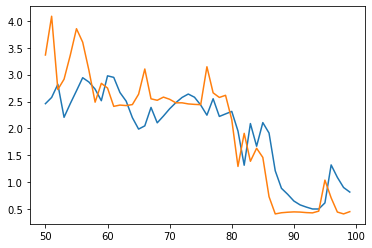

In [129]:
import matplotlib.pyplot as plt
plt.plot(train_results['train_predicted'][50:100])
plt.plot(train_results['train_target'][50:100])

In [130]:
test_predictions = model1.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [57]:
from sklearn.metrics import mean_squared_error,accuracy_score

In [131]:
mean_squared_error(test_results.test_predictions,test_results.test_target)

0.2706027

In [132]:
mean_squared_error(train_results.train_predicted,train_results.train_target)

0.33247894

**MODEL2..Conv1D**

In [90]:
model2 = Sequential()
model2.add(InputLayer((100, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 64)            192       
                                                                 
 flatten (Flatten)           (None, 6336)              0         
                                                                 
 dense_10 (Dense)            (None, 8)                 50696     
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 50,897
Trainable params: 50,897
Non-trainable params: 0
_________________________________________________________________


In [91]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [92]:
model2.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp2])

Epoch 1/10
710/719 [============================>.] - ETA: 0s - loss: 0.4978 - root_mean_squared_error: 0.7056INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 6ms/step - loss: 0.4958 - root_mean_squared_error: 0.7041 - val_loss: 0.3294 - val_root_mean_squared_error: 0.5740
Epoch 2/10
712/719 [============================>.] - ETA: 0s - loss: 0.3741 - root_mean_squared_error: 0.6116INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 4s 6ms/step - loss: 0.3737 - root_mean_squared_error: 0.6113 - val_loss: 0.3127 - val_root_mean_squared_error: 0.5592
Epoch 3/10
709/719 [============================>.] - ETA: 0s - loss: 0.3598 - root_mean_squared_error: 0.5999INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 4s 6ms/step - loss: 0.3603 - root_mean_squared_error: 0.6002 - val_loss: 0.3124 - val_root_mean_squared_error: 0.5589
Epoch 4/10
718/719 [============================>.] - ETA: 0s - loss: 0.3598 - root_mean_squared_error: 0.5998INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 5s 6ms/step - loss: 0.3596 - root_mean_squared_error: 0.5997 - val_loss: 0.3070 - val_root_mean_squared_error: 0.5541
Epoch 5/10
719/719 [==============================] - 4s 5ms/step - loss: 0.3601 - root_mean_squared_error: 0.6001 - val_loss: 0.3076 - val_root_mean_squared_error: 0.5546
Epoch 6/10
710/719 [============================>.] - ETA: 0s - loss: 0.3607 - root_mean_squared_error: 0.6006INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 4s 6ms/step - loss: 0.3602 - root_mean_squared_error: 0.6002 - val_loss: 0.3067 - val_root_mean_squared_error: 0.5538
Epoch 7/10
719/719 [==============================] - 4s 5ms/step - loss: 0.3585 - root_mean_squared_error: 0.5987 - val_loss: 0.3087 - val_root_mean_squared_error: 0.5556
Epoch 8/10
711/719 [============================>.] - ETA: 0s - loss: 0.3581 - root_mean_squared_error: 0.5984INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


719/719 [==============================] - 4s 6ms/step - loss: 0.3587 - root_mean_squared_error: 0.5989 - val_loss: 0.3065 - val_root_mean_squared_error: 0.5536
Epoch 9/10
719/719 [==============================] - 4s 5ms/step - loss: 0.3572 - root_mean_squared_error: 0.5977 - val_loss: 0.3072 - val_root_mean_squared_error: 0.5543
Epoch 10/10
719/719 [==============================] - 5s 7ms/step - loss: 0.3574 - root_mean_squared_error: 0.5978 - val_loss: 0.3081 - val_root_mean_squared_error: 0.5550


In [93]:
from tensorflow.keras.models import load_model
model2 = load_model('model2/')

In [94]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [95]:
test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [96]:
print(f"Test error...")
mean_squared_error(test_results.test_predictions,test_results.test_target)

Test error...


0.2830649

In [97]:
print(f"Training Error....")
mean_squared_error(train_results.train_predicted,train_results.train_target)

Training Error....


0.35355812

**Model3...GRU**

In [98]:
model3 = Sequential()
model3.add(InputLayer((100, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [105]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp3])

In [107]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')

In [108]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [109]:
print(f"Test error...")
mean_squared_error(test_results.test_predictions,test_results.test_target)

Test error...


0.2830649

In [110]:
print(f"Training Error....")
mean_squared_error(train_results.train_predicted,train_results.train_target)

Training Error....


0.35355812

In [ ]:
temp_df = pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

In [ ]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()